In [1]:
### LIBRARY
import os
import glob
from skimage import io
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from skimage.io import imsave
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from skimage.util import invert
from skimage.filters import try_all_threshold
from skimage.filters import threshold_minimum
from skimage.filters import threshold_triangle
from skimage.morphology import binary_erosion, binary_dilation
from scipy.ndimage import distance_transform_edt
from skimage.segmentation import watershed
from skimage.filters import gaussian
from skimage.morphology import label
from skimage.measure import regionprops
from skimage.segmentation import clear_border
from skimage.segmentation import relabel_sequential
from skimage.morphology import remove_small_objects
from skimage.morphology import remove_small_holes
from scipy.spatial.distance import cdist

from statistics import mean, stdev
import re
from natsort import natsorted

In [76]:
### LOADING

filename = 'C:/Users/terez/Documents/Skola/Ludwig-Maximilians_Universitat_Munchen/Research course Moretti lab/Microscopy data etc/Tereza/CAR_T/2025_04_09_14_28_44--CART organoids #2 with CARs Stain 1'

## tiff images:
## CAR-Ts in 594 channel:
list_of_mCherry_files = natsorted(glob.glob(f"{filename}/*C02*.tif"))
images_mCherry = {}
for file in list_of_mCherry_files:
    img = io.imread(file)
    images_mCherry[os.path.basename(file)] = img

## fibronectin in 647 channel:
list_of_fbn1_files = natsorted(glob.glob(f"{filename}/*C03*.tif"))
images_fbn1 = {}
for file in list_of_fbn1_files:
    img = io.imread(file)
    images_fbn1[os.path.basename(file)] = img

## DAPI in 405 channel:
list_of_dapi_files = natsorted(glob.glob(f"{filename}/*C00*.tif"))
images_dapi = {}
for file in list_of_dapi_files:
    img = io.imread(file)
    images_dapi[os.path.basename(file)] = img

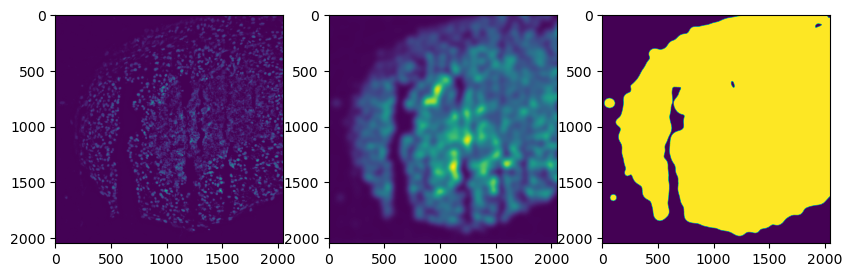

In [73]:
### EXPERIMENTING

# #FBN1:
# image_fbn1 = images_fbn1['ET1 CD10 1_25 d4 1--C03.tif']
# image_thresholded = image_fbn1 > threshold_otsu(image_fbn1)
# image_thresholded_2 = remove_small_objects(image_thresholded, min_size=100)
# image_thresholded_3 = remove_small_holes(image_thresholded_2, area_threshold=50)
# fig, axs = plt.subplots(ncols=3, figsize=(10,7))
# axs[0].imshow(image_thresholded)
# axs[1].imshow(image_thresholded_2)
# axs[2].imshow(image_thresholded_3)

# labelled_img = label(image_thresholded_3)
# fbn1_objects = regionprops(labelled_img, image_fbn1)

# obj_data_fbn1 = []
# for obj in fbn1_objects:
#     obj_data_fbn1.append(obj.area)

# mean_fbn1_size = mean(obj_data_fbn1)
# overal_fbn1_signal = np.sum(image_thresholded_3)
# overal_fbn1_signal_2 = np.sum(labelled_img>0)
# print(overal_fbn1_signal)
# print(overal_fbn1_signal_2)

# #CART:
# image_cart = images_mCherry['ET1 FAP 1_25 6d 3--C02.tif']
# tresh_otsu_1 = image_cart > threshold_triangle(image_cart)
# tresh_otsu_2 = remove_small_objects(tresh_otsu_1, min_size=50)
# # fig, ax = try_all_threshold(image_cart, figsize=(6, 12), verbose=False)
# # plt.show()
# fig, axs = plt.subplots(ncols=2, figsize=(10,7))
# axs[0].imshow(image_thresholded_3)
# axs[1].imshow(tresh_otsu_2)

#DAPI/organoid area:
image_dapi = images_dapi['ET1 CD10 1_25 d4 3--C00.tif']
blurred_dapi = gaussian(image_dapi, sigma=30)

# fig, ax = try_all_threshold(blurred_dapi, figsize=(6, 12), verbose=False)
# plt.show() #minimum or triangle

image_thresholded = blurred_dapi > threshold_triangle(blurred_dapi)
fig, axs = plt.subplots(ncols=3, figsize=(10,7))
axs[0].imshow(image_dapi)
axs[1].imshow(blurred_dapi)
axs[2].imshow(image_thresholded)



In [79]:
### Analysis (hopefully)

Image_data_stain1 = {}

for name,img in images_mCherry.items():

    ## CAR_T
    thresholded_img = img > threshold_triangle(img)
    thresholded_img_2 = remove_small_objects(thresholded_img, min_size=50)

    labelled_CART_img = label(thresholded_img_2)
    objects = regionprops(labelled_CART_img, img)

    obj_data = []
    for obj in objects:
        obj_data.append(obj.area)
    
    if len(obj_data) == 0:
        mean_CAR_T_size = np.nan
        overal_CAR_T_signal = 0
    else:
        mean_CAR_T_size = mean(obj_data)
        overal_CAR_T_signal = np.sum(thresholded_img_2)


    ## FBN1
    name_without_last_part = '--'.join(name.split('--')[:-1])
    img_fbn1 = images_fbn1[f'{name_without_last_part}--C03.tif']

    thresholded_fbn1_img = img_fbn1 > threshold_otsu(img_fbn1)
    thresholded_fbn1_img_2 = remove_small_objects(thresholded_fbn1_img, min_size=100)
    thresholded_fbn1_img_3 = remove_small_holes(thresholded_fbn1_img_2, area_threshold=50)

    labelled_fbn1_img = label(thresholded_fbn1_img_3)
    fbn1_objects = regionprops(labelled_fbn1_img, img_fbn1)

    obj_data_fbn1 = []
    for obj in fbn1_objects:
        obj_data_fbn1.append(obj.area)

    if len(obj_data_fbn1) == 0:
        mean_CAR_T_size = np.nan
        overal_CAR_T_signal = 0
    else:
        mean_fbn1_size = mean(obj_data_fbn1)
        overal_fbn1_signal = np.sum(thresholded_fbn1_img_3)

    ## analysis of the average shortest distance between the CAR_T and fibronectin signal
    centroids_A = [obj.centroid for obj in objects]
    centroids_B = [obj.centroid for obj in fbn1_objects]

    if len(centroids_A) == 0 or len(centroids_B) == 0:
        print(f"The {name_without_last_part} mask has no objects!")
        average_distance = np.nan

    else:
        # Step 3: Compute pairwise distances (Y, X format)
        distances = cdist(centroids_A, centroids_B)  # shape: (len(A), len(B))

        # Step 4: Find the minimum distance from each A-object to B
        min_distances = np.min(distances, axis=1)

        # Step 5: Compute average shortest distance
        average_distance = np.mean(min_distances)

    ## DAPI
    img_dapi = images_dapi[f'{name_without_last_part}--C00.tif']
    dapi_gaussian_blurred = gaussian(img_dapi, sigma=30)
    image_thresholded = dapi_gaussian_blurred > threshold_triangle(dapi_gaussian_blurred)
    organoid_size = np.sum(image_thresholded)

    Image_data_stain1[name_without_last_part] = {
        'mean_CART_size': mean_CAR_T_size,
        'CART_area': overal_CAR_T_signal,
        'CART_number': len(obj_data),
        'mean_fbn1_size': mean_fbn1_size,
        'fbn1_area': overal_fbn1_signal,
        'distance_CART_to_fbn1': average_distance,
        'organoid_size': organoid_size
    }

The ET1 CD10 1_25 d4 1 mask has no objects!
The ET1 CD10 1_25 d4 2 mask has no objects!
The ET1 CD10 1_25 d4 3 mask has no objects!
The ET1 CD19 1_100 72h #39 2 mask has no objects!


In [80]:
### DATAFRAME
df_stain1 = pd.DataFrame.from_dict(Image_data_stain1, orient='index')

df_stain1.head()
df_stain1.to_excel('stain1_analysis_results.xlsx')


## NOTE: sort by relative area to the image (in percentages, not pixels)
## NOTE: maybe manually add the CM area to the excel
## NOTE: check if the values fit (they do seem to tho)